In [1]:
!pip install torch_geometric


##**Importing Necessary Libraries**##



In [2]:
import torch  # PyTorch for deep learning
from torch_geometric.datasets import Planetoid  # a dataset class provides common citation network datasets like Cora, CiteSeer, and PubMed.
from torch_geometric.nn import Node2Vec  # Import the Node2Vec class from PyTorch Geometric
from sklearn.manifold import TSNE  # For dimensionality reduction (used for visualization)
import matplotlib.pyplot as plt  # For plotting visualizations

In [3]:
torch.__version__

'2.4.1+cu121'

In [4]:
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html


##**Load the Cora Dataset**##

Cora dataset is a citation network where nodes represent papers, and edges represent citations between them.

In [5]:
path = "C:/Users/iDEAL/Desktop"  # Path to download the dataset
dataset = Planetoid(path, "Cora")  # Downloads and loads the Cora dataset
data = dataset[0]  # Get the first (and only) graph from the dataset

In [6]:
print('Cora:', data)  # Print the structure of the Cora data object

Cora: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


##**Setting Device**##

In [7]:
# Check if GPU (CUDA) is available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Prints the selected device ("cuda" or "cpu").
print('Device: {}'.format(device))

Device: cpu


##**Construct the Node2Vec Model**##

In [8]:
node2vec_model = Node2Vec(
    data.edge_index,  # Edge list (connections between nodes in the graph)
    embedding_dim=128,  # Dimension of the embedding vectors
    walk_length=20,  # The length of each random walk (number of steps). How far each random walk will traverse.
    context_size=10,  # The size of the context window (inspired by Word2Vec) that captures neighboring nodes during training.
    walks_per_node=10,  # Number of random walks to perform for each node
    num_negative_samples=1,  # Negative sampling parameter (used to distinguish between actual node pairs and random ones).
    '''
    it means that for every positive sample (random walk), the model will generate one negative sample.
    Negative samples help the model discriminate between connected and non-connected nodes.
    Without negative samples, the model might just cluster all the nodes together in the embedding space,
    because it only sees "positive" relationships. Negative samples give the model contrasting examples of nodes
    that should not be similar, which helps create better separation in the embedding space.
    '''
    p=1, q=1,  # These are the return and in-out parameters that control the random walk behavior
    sparse=True  # This uses sparse embeddings for efficiency when handling large graphs.
).to(device)  # Move the model to the available device (CPU or GPU)

##**Create a DataLoader**##

This creates a data loader for batch processing during training. It samples random walks and organizes them in batches.

In [9]:
loader = node2vec_model.loader(batch_size=128, # Number of random walks per batch.
                               shuffle=True, # Shuffles the random walks between batches to improve generalization.
                               num_workers=4) # Number of parallel workers used for loading the data.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
# Print an example from the DataLoader to check
for batch in loader:
    print(batch)
    print(batch[0])
    print(len(batch))
    break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(tensor([[  76, 2018,  356,  ...,  211,  164,  210],
        [ 579,  994,  579,  ...,  733, 2291,  715],
        [1046, 2336, 1202,  ..., 1202, 1510, 1162],
        ...,
        [1358,   72, 1358,  ..., 1546, 1804, 1740],
        [1358, 1727, 1358,  ..., 1620, 2450, 2113],
        [1619,  392, 2269,  ..., 2375,   20, 2374]]), tensor([[  76, 2113,  478,  ..., 1848, 1996, 1168],
        [ 579, 2370,  691,  ..., 1872,   51,  741],
        [1046, 1831, 1125,  ...,   49,  806, 1522],
        ...,
        [1462, 1028, 1968,  ...,  873, 2059,  815],
        [2032, 2413, 1034,  ...,  259, 1400, 2213],
        [ 790,  252,  852,  ...,   75, 2550, 2649]]))
tensor([[  76, 2018,  356,  ...,  211,  164,  210],
        [ 579,  994,  579,  ...,  733, 2291,  715],
        [1046, 2336, 1202,  ..., 1202, 1510, 1162],
        ...,
        [1358,   72, 1358,  ..., 1546, 1804, 1740],
        [1358, 1727, 1358,  ..., 1620, 2450, 2113],
        [1619,  392, 2269,  ..., 2375,   20, 2374]])
2


In [17]:
i = 0
for batch in loader:
  i += 1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
print(i)

22


##**Training Function**##

In [10]:
# Define the optimizer
optimizer = torch.optim.SparseAdam(
    list(node2vec_model.parameters()),  # List of the model's parameters to optimize
    lr=0.01  # Learning rate for optimization
)

'''
SparseAdam: This is an Adam optimizer variant that is optimized for sparse embeddings.
It updates only the non-zero parts of the embedding, which is more efficient.
'''

'\nSparseAdam: This is an Adam optimizer variant that is optimized for sparse embeddings. \nIt updates only the non-zero parts of the embedding, which is more efficient.\n'

In [30]:
# Training function
def train():
    node2vec_model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss to 0

    for pos_rw, neg_rw in loader:
      '''
      Loops over the positive and negative random walks generated by the data loader.
      pos_rw are the real node sequences (random walks), while neg_rw are negative samples.
      For example, in a citation network like the Cora dataset, if node A cites node B, which cites node C,
      then the sequence (A, B, C) might form part of a positive random walk.
      This reflects meaningful relationships between these nodes.
      For instance, if node A does not have any meaningful connection to node D,
      but a random sequence (A, X, D) is generated, it represents a negative random walk.
      '''
      optimizer.zero_grad()  # Zero the gradients from the previous step
      loss = node2vec_model.loss(pos_rw, neg_rw)  # Calculate the loss between positive and negative samples
      '''
      The loss function tries to maximize similarity between nodes in the positive walks
      and minimize similarity between those in negative walks.
      '''
      loss.backward()  # Perform backpropagation to compute gradients
      optimizer.step()  # Update the model's parameters using the computed gradients
      total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(loader)  # Return the average loss over the batches in the current epoch.

In [31]:
# Training Loop ==> GET EMBEDDING
# Train the model for 100 epochs
for epoch in range(1, 101):
    loss = train()  # Call the train function for each epoch
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')  # Print the loss for each epoch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 01, Loss: 8.1215
Epoch: 02, Loss: 6.0676
Epoch: 03, Loss: 4.9478
Epoch: 04, Loss: 4.1418
Epoch: 05, Loss: 3.4823
Epoch: 06, Loss: 2.9654
Epoch: 07, Loss: 2.5547
Epoch: 08, Loss: 2.2204
Epoch: 09, Loss: 1.9544
Epoch: 10, Loss: 1.7409
Epoch: 11, Loss: 1.5701
Epoch: 12, Loss: 1.4315
Epoch: 13, Loss: 1.3169
Epoch: 14, Loss: 1.2340
Epoch: 15, Loss: 1.1619
Epoch: 16, Loss: 1.1067
Epoch: 17, Loss: 1.0605
Epoch: 18, Loss: 1.0244
Epoch: 19, Loss: 0.9948
Epoch: 20, Loss: 0.9726
Epoch: 21, Loss: 0.9512
Epoch: 22, Loss: 0.9360
Epoch: 23, Loss: 0.9215
Epoch: 24, Loss: 0.9119
Epoch: 25, Loss: 0.9037
Epoch: 26, Loss: 0.8935
Epoch: 27, Loss: 0.8860
Epoch: 28, Loss: 0.8799
Epoch: 29, Loss: 0.8756
Epoch: 30, Loss: 0.8692
Epoch: 31, Loss: 0.8659
Epoch: 32, Loss: 0.8627
Epoch: 33, Loss: 0.8604
Epoch: 34, Loss: 0.8579
Epoch: 35, Loss: 0.8535
Epoch: 36, Loss: 0.8516
Epoch: 37, Loss: 0.8510
Epoch: 38, Loss: 0.8485
Epoch: 39, Loss: 0.8461
Epoch: 40, Loss: 0.8445
Epoch: 41, Loss: 0.8436
Epoch: 42, Loss:

In [32]:
# Visualize the Embeddings in 2D
@torch.no_grad()  # Disable gradient calculation for this block (just visualizing and not updating model parameters, saves memory and computations)
def plot_point(colors):
    node2vec_model.eval()  # Set the model to evaluation mode (disable dropout, etc.)
    # Generate the embeddings for all nodes in the graph
    z = node2vec_model(torch.arange(data.num_nodes, device=device))
    # Reduce the dimensionality of the embeddings to 2D for visualization using t-SNE
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    # Get the labels (node classes) and move them to the CPU for plotting
    y = data.y.cpu().numpy()

    # Create a scatter plot to visualize the nodes in 2D space
    plt.figure()
    for i in range(dataset.num_classes):  # For each class of nodes
        # Scatter plot the nodes of the same class with the same color
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')  # Turn off the axis for better visualization
    plt.show()  # Display the plot

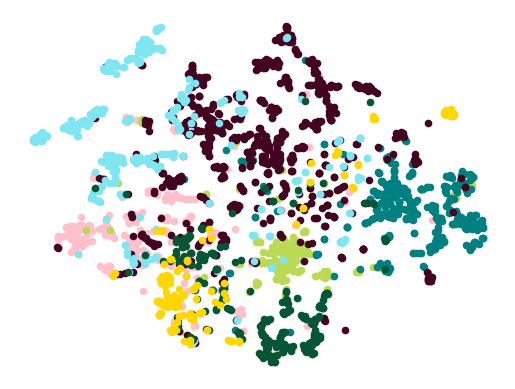

In [33]:
# Plot the Embeddings
# Define a list of colors for each class in the dataset
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
# Call the function to plot the 2D visualization of the embeddings
plot_point(colors)

##**Node Classification Function**##

In [34]:
def test():
    node2vec_model.eval()  # Set the model to evaluation mode
    # Generate embeddings for all nodes
    z = node2vec_model()
    # Perform node classification using the embeddings
    acc = node2vec_model.test(
        z[data.train_mask], data.y[data.train_mask],  # Train on the training nodes
        z[data.test_mask], data.y[data.test_mask],  # Test on the testing nodes
        max_iter=150  # Maximum number of iterations for classification
    )
    return acc  # Return the classification accuracy

In [35]:
# Print the node classification accuracy
print('Accuracy:', test())

Accuracy: 0.719
